<a href="https://colab.research.google.com/github/TMKarunarathne/FYP/blob/main/SpatioXxX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Spatio-temporal 15x15**


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.io
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Flatten
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Conv2D,ConvLSTM2D,BatchNormalization,Conv3D, Conv1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate,Reshape
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
#from test_utils import summary, comparator
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

rand_state =1000

Mounted at /content/gdrive
Mounted at /content/gdrive


In [ ]:
#mat_file = '/content/gdrive/MyDrive/Data_Set/FV_10000x8928_01.mat'
#mat = scipy.io.loadmat(mat_file)

In [ ]:
#mat

In [ ]:
#mat('df')

In [ ]:
path = '/content/gdrive/MyDrive/Data_Set/FV_all_in_one.csv'
df = pd.read_csv(path)
df = df.drop(df.columns[[0]], axis=1)


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'] , unit="s")
#df.set_index(df['Datetime'] ,inplace=True)
#df = df.drop(df.columns[[0]], axis=1)
#df.head()

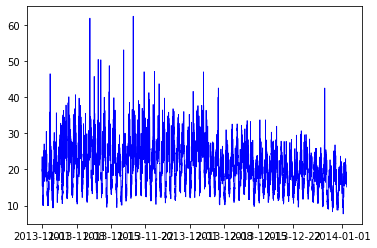

In [ ]:
cell_no = 4098 # select a cell
cell_data = df.iloc[:,cell_no]
plt.plot( df['Datetime'],cell_data ,color = 'blue', linewidth=0.8)

In [ ]:
dfdata = df.iloc[:,1:10001].to_numpy()
dfdata.shape

(8928, 10000)

In [ ]:
dd = dfdata[0:3,0:3]

In [ ]:
dd.reshape(-1)
dd

array([[11.02836638, 11.05822481, 11.09000792],
       [11.12710088, 11.16792632, 11.21138339],
       [10.8927706 , 10.91563796, 10.93997935]])

In [ ]:
arr3d = dfdata.reshape(8928, 100, 100)
#arr3d

In [ ]:
shapeData = arr3d.shape

In [ ]:
arr3d[1,0,0]

11.1271008756737

In [ ]:
numInps = 5
length = shapeData[0]

In [ ]:
ss = np.zeros((2,2))
ss[1,1]  = arr3d[1,0,0]
ss[1,1]

11.1271008756737

In [ ]:
def shapingInputs( arr3d , numInps ):
  shapeData = arr3d.shape
  X = np.zeros(( shapeData[0]-numInps , numInps , shapeData[1] , shapeData[2] ))
  Y = arr3d[numInps :]

  for i in range(0,shapeData[0]-numInps):
    X[i] = arr3d[i:i+numInps]

  return X/2000 , Y/2000

In [ ]:
stx = 0 # start
sty = 0 # start 
w  = 100 # width
X ,Y = shapingInputs( arr3d[:144*20,stx:stx+w,sty:sty+w] , numInps )

In [ ]:
X.shape

(2875, 5, 100, 100)

In [ ]:
Y.shape

(2875, 100, 100)

In [ ]:
Y1 = Y.reshape(-1, w, w,1)
Y1.shape

(2875, 100, 100, 1)

## **3D array was created...**

In [ ]:
# Make sure images have shape (28, 28, 1)
x_train = X.transpose((0,2,1,3))
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
#print(x_test.shape[0], "test samples")


x_train shape: (2875, 100, 5, 100)
2875 train samples


In [ ]:
#Z = arr3d[1,:,:]
Z = x_train[1,:,4,:]

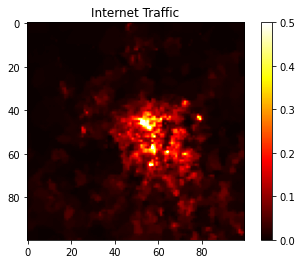

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Z,cmap="hot")
plt.title("Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
plt.show()

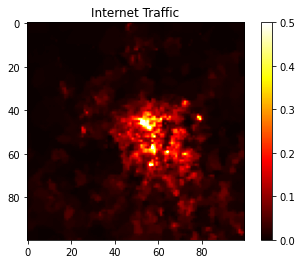

In [ ]:
Z1 = Y1[0,:,:,0]
plt.imshow(Z1,cmap="hot")
plt.title("Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
plt.show()

## **Move to CNN**

In [ ]:
def convBlock(X, f, filters, w,training=True, initializer=random_uniform):
    
    F1, F2 = filters
    
    # First component of main path
    X = Reshape((w,w,1))(X)

    X = Conv2D(filters = F1, kernel_size = 3, strides = 2, padding = 'valid', kernel_initializer = initializer(seed=0))(X) #7x7
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = 3, strides = 2, padding = 'valid', kernel_initializer = initializer(seed=0))(X)  #3x3
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    return X

In [ ]:
def MySpatio(input_shape = (w, 5, w)):

    X_input = Input(input_shape)
    X1 = X_input[:,:,0]
    X2 = X_input[:,:,1]
    X3 = X_input[:,:,2]
    X4 = X_input[:,:,3]
    X5 = X_input[:,:,4]

    X1 = convBlock(X1, 3, [8, 8],w)
    X2 = convBlock(X2, 3, [8, 8],w)
    X3 = convBlock(X3, 3, [8, 8],w)
    X4 = convBlock(X4, 3, [8, 8],w)
    X5 = convBlock(X5, 3, [8, 8],w)

    X1 = Flatten()(X1)
    X2 = Flatten()(X2)
    X3 = Flatten()(X3)
    X4 = Flatten()(X4)
    X5 = Flatten()(X5)
    #print(X1.shape)

    X = concatenate([X1, X2, X3, X4, X5], axis=1 )
    #print(X.shape)

    X = Reshape((-1,5))(X)
    #print(X.shape)

    X = LSTM(100, return_sequences=True)(X) 
    #print('Hi 1')
    #print(X.shape)
    X = LSTM(w*w)(X)
    #print('Hi 2')
    #print(X.shape)
    X = Reshape((w,w))(X)

    # The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
#model = MySpatio(input_shape = (w,5,w))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 5, 25)]  0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 25, 25)      0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 25, 25)      0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

In [ ]:
x_train.shape

(8923, 100, 5, 100)

In [ ]:
#model.compile(loss="mse", optimizer="adam", metrics=["MeanAbsolutePercentageError"])
model.compile(loss="mse", optimizer="adam", metrics=["MeanSquaredError"])

In [ ]:
batch_size = 16
epochs = 3

In [ ]:
#model_cnn.fit( x_train, Y, batch_size=batch_size, epochs=epochs, validation_split=0.4)
#model_cnn.fit( x_train , Y1, batch_size=batch_size, epochs=epochs, validation_split=0.4)
model.fit( x_train[0:8000] , Y[0:8000], batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/3
400/400 [==============================] - 1005s 2s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2/3
400/400 [==============================] - 1073s 3s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 3/3
400/400 [==============================] - 1073s 3s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0025 - val_mean_squared_error: 0.0025


In [ ]:
model.save('/content/gdrive/MyDrive/Data_Set/Spatio1XxX_0224_01.model')
#model = tf.keras.models.load_model("/content/gdrive/MyDrive/Data_Set/Spatio1XxX_0216_03.model")

Epoch 1/10
43/43 [==============================] - 72s 2s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 2/10
43/43 [==============================] - 71s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 3/10
43/43 [==============================] - 70s 2s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 4/10
43/43 [==============================] - 69s 2s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 5/10
43/43 [==============================] - 70s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 6/10
43/43 [==============================] - 70s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 7/10
43/43 [======================

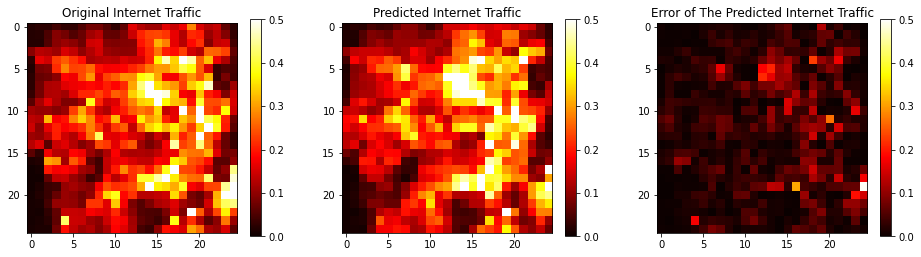

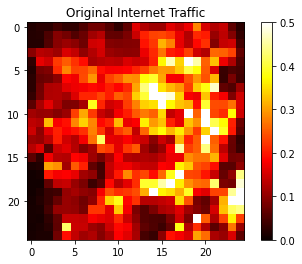

In [ ]:
start = 144*14
stx = 40
sty = 40
w = 25
le = 144*6
i = 60
model.fit( x_train[start:start+le,stx:stx+w , :, sty:sty+w] , Y[start:start+le,stx:stx+w , sty:sty+w], batch_size=16, epochs=10, validation_split=0.2)

start = 144*15
le =144*5
valPredict = model.predict(x_train[start:start+le,stx:stx+w , :, sty:sty+w]) #stx:stx+w,sty:sty+w
yout = Y[start : start + valPredict.shape[0],stx:stx+w , sty:sty+w]

fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
Z1 = yout[i,:,:]
plt.imshow(Z1,cmap="hot")
plt.title("Original Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
# #plt.show()

plt.subplot(1, 3, 2)
Z2 = valPredict[i,:,:]
plt.imshow(Z2,cmap="hot")
plt.title("Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()

plt.subplot(1, 3, 3)
Z3 = abs(Z2-Z1)
plt.imshow(Z3,cmap="hot")
plt.title("Error of The Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spatio_25x25/Spatio25x25_'+ str(stx) + '_' + str(sty) +'_comp.png',transparent=True)
# #plt.show()

fig = plt.figure(figsize=(6, 4))    
Z1 = yout[i,:,:]
plt.imshow(Z1,cmap="hot")
plt.title("Original Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spatio_25x25/Spatio25x25_on_'+ str(stx) + '_' + str(sty) +'_comp.png',transparent=True)




In [ ]:
# for i in [0,25,50,75]:
#   for j in [0,25,50,75]:
#     #print('y :',i,'  x :',j)
#     start = 0
#     stx = i
#     sty = j
#     w = 25
#     le = 144
#     model.fit( x_train[start:start+le,stx:stx+w , :, sty:sty+w] , Y[start:start+le,stx:stx+w , sty:sty+w], batch_size=16, epochs=1, validation_split=0.2)

#     start = 144*0
#     le = 25
#     valPredict = model.predict(x_train[start:start+le,stx:stx+w , :, sty:sty+w]) #stx:stx+w,sty:sty+w
#     yout = Y[start : start + valPredict.shape[0],stx:stx+w , sty:sty+w]
#     # print('pred shape = ',valPredict.shape)
#     # print('yout shape = ',yout.shape)

#     i = 20
#     fig = plt.figure(figsize=(6, 4))
#     # plt.subplot(1, 3, 1)
#     Z1 = yout[i,:,:]
#     plt.imshow(Z1,cmap="hot")
#     plt.title("Original Internet Traffic")
#     plt.clim( 0,.5)
#     plt.colorbar()
#     # #plt.show()

#     # plt.subplot(1, 3, 2)
#     # Z2 = valPredict[i,:,:]
#     # plt.imshow(Z2,cmap="hot")
#     # plt.title("Predicted Internet Traffic")
#     # plt.clim( 0,.5)
#     # plt.colorbar()

#     # plt.subplot(1, 3, 3)
#     # Z3 = abs(Z2-Z1)
#     # plt.imshow(Z3,cmap="hot")
#     # plt.title("Error of The Predicted Internet Traffic")
#     # plt.clim( 0,.5)
#     # plt.colorbar()
#     plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spatio_25x25/Spatio25x25_'+ str(stx) + '_' + str(sty) +'_comp.png',transparent=True)
#     # #plt.show()

#     fig = plt.figure(figsize=(6, 4))    
#     Z1 = yout[i,:,:]
#     plt.imshow(Z1,cmap="hot")
#     plt.title("Original Internet Traffic")
#     plt.clim( 0,.5)
#     plt.colorbar()
#     plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spatio_25x25/Spatio25x25_on_'+ str(stx) + '_' + str(sty) +'_comp.png',transparent=True)




  

In [ ]:
X.shape

(8923, 5, 25, 25)

In [ ]:
x_train.shape

(8923, 100, 5, 100)

In [ ]:
Y.shape

(8923, 25, 25)

In [ ]:
start = 144*13
stx = 40
sty = 40
w = 25
le = 144*5
valPredict = model.predict(x_train[start:start+le,stx:stx+w , :, sty:sty+w]) #stx:stx+w,sty:sty+w
yout = Y[start : start + valPredict.shape[0],stx:stx+w , sty:sty+w]
print('pred shape = ',valPredict.shape)
print('yout shape = ',yout.shape)

23/23 [==============================] - 13s 558ms/step
pred shape =  (720, 25, 25)
yout shape =  (720, 25, 25)


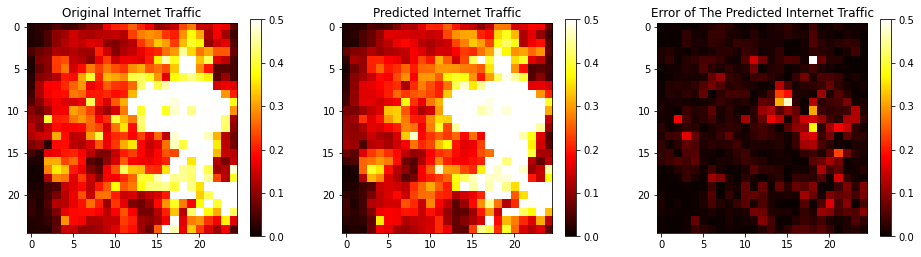

In [ ]:
i = 60
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
Z1 = yout[i,:,:]
plt.imshow(Z1,cmap="hot")
plt.title("Original Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
#plt.show()

plt.subplot(1, 3, 2)
Z2 = valPredict[i,:,:]
plt.imshow(Z2,cmap="hot")
plt.title("Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()

plt.subplot(1, 3, 3)
Z3 = abs(Z2-Z1)
plt.imshow(Z3,cmap="hot")
plt.title("Error of The Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
#plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spatio_25x25/Spatio25x25_'+ str(stx) + '_' + str(sty) +'_comp.png',transparent=True)
plt.show()



In [ ]:
print(Z3.max())
print(Z3.min())

0.4956175777805325
4.230741240278391e-06


In [ ]:
def absError(y , ypred):
  i = 1
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.absolute(ypred - y) , y))/(ypred.shape[1] * ypred.shape[2])/ypred.shape[0]
  return np.sum(dif)


def msep(y , ypred):
  i = 1
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.square(ypred - y) , np.square(y) ))/(ypred.shape[1] * ypred.shape[2])/ypred.shape[0]
  return np.sum(dif)

In [ ]:
print('Absolute percentage error is = ' , absError(yout , valPredict))
print('Absolute percentage mse is = ' , msep(yout , valPredict))

Absolute percentage error is =  0.29148177112041207
Absolute percentage mse is =  0.22090587229102365


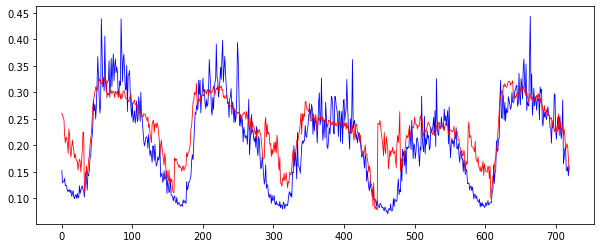

In [ ]:
fig = plt.figure(figsize=(10, 4)) #xx=10 yy=20
xx = 10
yy = 5
plt.plot( yout[0:720,xx,yy] ,color = 'blue', linewidth=0.8)
plt.plot( valPredict[0:720,xx,yy] ,color = 'red', linewidth=0.8)